In [1]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.pool import NullPool
import matplotlib as plt
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import requests
from io import BytesIO



In [2]:
bun_uids = pd.read_csv('./번개장터 어드민 uid 목록_20200723.csv')

In [3]:
bun_uids = ','.join('\''+str(i)+'\'' for i in bun_uids['uid'])

9/4 ~ 10/4 한달간 15일 이상 로그인한 사람들에게  
10/5 ~ 10/7 동안 상품이 '검색결과'로 노출되는 경우  
(번장 어드민 uid 도 제외)

In [80]:
q = f'''
SELECT i.YEAR||i.MONTH||i.DAY AS DAY,
       i.imp_id,
       i.ref_term,
       i.content_id,
       p.uid AS content_owner,
       i.ref_source
FROM bun_log_db.app_event_type_impression i
JOIN service1_quicket.product_info p ON i.content_id = p.id
JOIN
  (SELECT user_id AS uid
   FROM bun_log_db.app_event_type_launch
   WHERE YEAR||MONTH||DAY BETWEEN '20200904' AND '20201004'
   GROUP BY 1
   HAVING count(*) >= 15) u ON i.user_id = u.uid
WHERE i.page_id = '검색결과'
  AND i.device_type = 'a'
  AND i.YEAR||i.MONTH||i.DAY BETWEEN '20201005' AND '20201007'
  AND i.user_id NOT IN ({bun_uids})
'''

df = pd.read_sql(q, con=bun_dw)

KeyboardInterrupt: 

In [10]:
df.to_csv('imp_by_search_df.csv', index=False)

In [46]:
ad = df[~df['ref_source'].isnull()]

In [35]:
non_ad = df[df['ref_source'].isnull()]

In [36]:
eighteen = non_ad[non_ad['day'] == '20200918']

In [37]:
df18 = pd.merge(eighteen.groupby('content_owner')['content_id'].nunique().reset_index(), 
                eighteen.groupby('content_owner')['imp_id'].count().reset_index(),
                on = 'content_owner')

In [39]:
df18.columns = ['content_owner', 'content_cnt', 'imp_cnt']

up을 사용한 것과 안한 것 구분

In [51]:
eighteen.head()

,day,imp_id,ref_term,content_id,content_owner,ref_source
833,20200918,97395f64c4f63bd54dbe,정품케이스 아이폰x,133061109,9061122,None
834,20200918,99cb5f64c4603bd6c2a4,비비안웨스트우드,132787766,666252,None
835,20200918,97ce5f64cac63bef34b9,알렉산더 맥퀸 부산,133124475,12301031,None
836,20200918,97395f64c8303bec9887,애플워치,133645814,11824900,None
837,20200918,97665f64c2fd3bbe3f1f,빅톤,132226572,5454678,None


In [54]:
q = '''
SELECT pid,
       up_type
FROM up_count_history
WHERE register_at BETWEEN '2021-01-18 00:00:00' AND '2021-01-18 23:59:59'
'''
up = pd.read_sql(q, con=mysql)

In [55]:
up

,pid,up_type
0,104327088.0,1
1,132879136.0,2
2,132877635.0,2
3,111502583.0,1
4,115426896.0,1
5,119627257.0,1
6,131719979.0,1
7,133570562.0,1
8,132876891.0,2
9,130597239.0,1


In [47]:
ad_18 = ad[ad['day'] == '20200918']
ad18 = pd.merge(ad_18.groupby('content_owner')['content_id'].nunique().reset_index(), 
                ad_18.groupby('content_owner')['imp_id'].count().reset_index(),
                on = 'content_owner')

In [48]:
ad18.columns = ['content_owner', 'content_cnt', 'imp_cnt']

Text(0, 0.5, 'imp count')

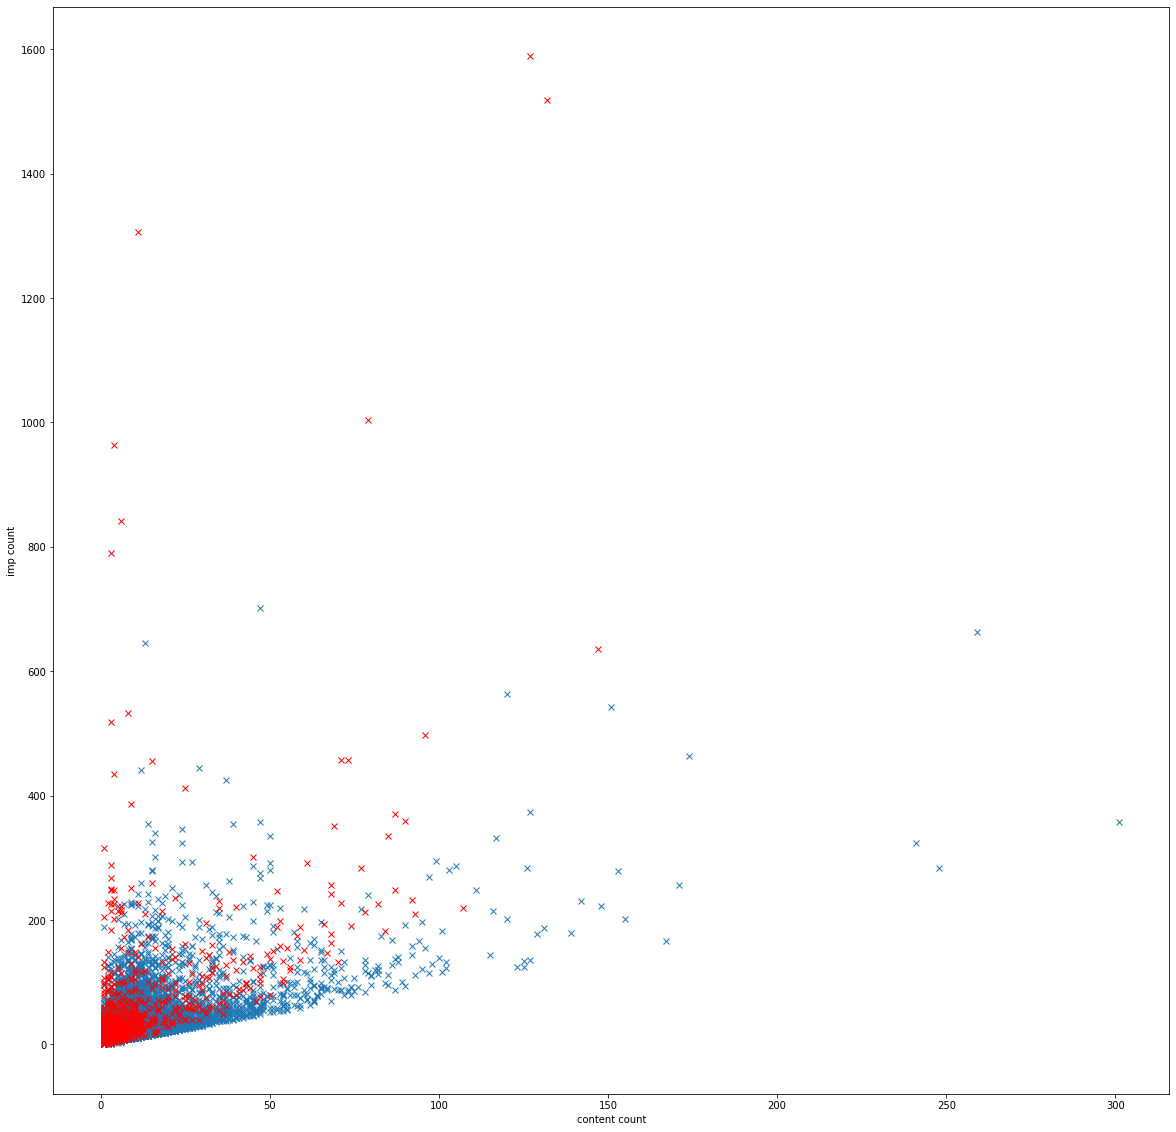

In [57]:
plt.figure(figsize=(20,20))
plt.plot(df18[df18['imp_cnt']<3000]['content_cnt'], df18[df18['imp_cnt']<3000]['imp_cnt'], 'x')
plt.plot(ad18['content_cnt'], ad18['imp_cnt'], 'x', color = 'red')
plt.xlabel('content count')
plt.ylabel('imp count')

In [58]:

df18.shape

(175568, 3)

Text(0, 0.5, 'imp count')

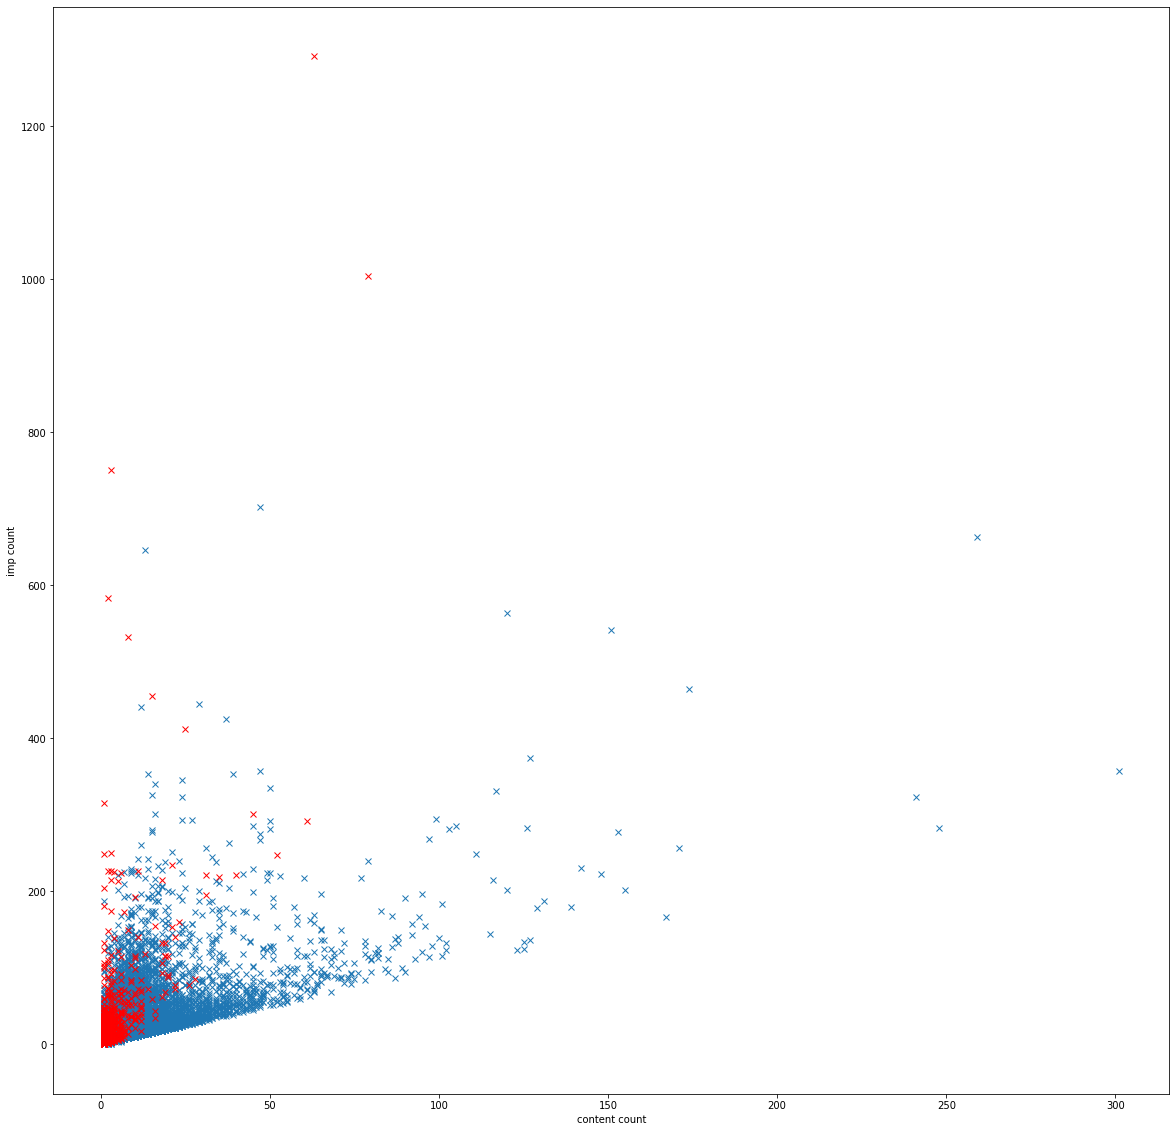

In [63]:
tmp = ad_18[ad_18['ref_source'].isin(['power_up', 'ad_super_up'])]
tmp_ = pd.merge(tmp.groupby('content_owner')['content_id'].nunique().reset_index(), 
                tmp.groupby('content_owner')['imp_id'].count().reset_index(),
                on = 'content_owner')
tmp_.columns = ['content_owner', 'content_cnt', 'imp_cnt']
plt.figure(figsize=(20,20))
plt.plot(df18[df18['imp_cnt']<3000]['content_cnt'], df18[df18['imp_cnt']<3000]['imp_cnt'], 'x')
plt.plot(tmp_['content_cnt'], tmp_['imp_cnt'], 'x', color = 'red')
plt.xlabel('content count')
plt.ylabel('imp count')


In [65]:
tmp_[(tmp_['imp_cnt']<100)&(tmp_['content_cnt']<5)]

,content_owner,content_cnt,imp_cnt
1,18251,2,5
2,20551,2,9
3,22694,2,6
4,26125,2,9
5,33650,1,1
7,53849,1,1
9,61890,1,1
10,62949,1,1
12,66707,1,2
13,72867,1,12


In [68]:
df[df['content_owner'] == 12415700]

,day,imp_id,ref_term,content_id,content_owner,ref_source
2720673,20200918,99cb5f643d1138b8636a,아이폰7,133563563,12415700,ad_super_up
2720800,20200918,97ce5f643cfe38a26827,아이폰7,133563563,12415700,ad_super_up
2767661,20200918,97395f64547a392ee9ff,아이폰7플러스 128,133563563,12415700,ad_super_up
2767727,20200918,971b5f6453b139442a72,아이폰7,133563563,12415700,ad_super_up
2895311,20200918,97ce5f647b0639f93530,아이폰7 128,133563563,12415700,ad_super_up
2895344,20200918,97ce5f647a9c39f6f234,아이폰7 128,133563563,12415700,ad_super_up
2895361,20200918,97395f647b293a0a53a9,아이폰7 128,133563563,12415700,ad_super_up
2895368,20200918,97ce5f647b5b39fb2440,아이폰7 128,133563563,12415700,ad_super_up
2895386,20200918,99cb5f64830a3a3afd44,아이폰7 128,133563563,12415700,ad_super_up
2895391,20200918,97395f647ac73a0842d3,아이폰7 128,133563563,12415700,ad_super_up
